# 자연어 처리
- NLP (Natural Language Processing)
- 사람이 사용하는 언어를 처리하고 해석

## 자연어 처리 기초

### 형태소 분석기
- konipy: 한국어 처리를 위한 형태소 분석기
- 형태소: 의미를 가지는 요소로서는 더 이상 분석할 수 없는 가장 작은 말의 단위

In [11]:
# 라이브러리
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [12]:
# konlpy 설치
# import sys
# !{sys.executable} -m pip install konlpy

In [13]:
# pip list

In [14]:
# 라이브러리
import konlpy
from konlpy.tag import Okt
tokenizer = Okt()

In [15]:
# 토큰화 ( 형태소 단위 )
text = "오늘 비가 와서 기분이 우울해요"
tokenizer.morphs(text)

['오늘', '비', '가', '와서', '기분', '이', '우울해요']

In [16]:
# 토큰화
tokenizer.pos(text)

[('오늘', 'Noun'),
 ('비', 'Noun'),
 ('가', 'Josa'),
 ('와서', 'Verb'),
 ('기분', 'Noun'),
 ('이', 'Josa'),
 ('우울해요', 'Adjective')]

### CountVectorizer

In [17]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [18]:
# 단어 토큰화
words = tokenizer.morphs(text)

In [19]:
# 데이터 학습
vect.fit(words)

CountVectorizer()

In [20]:
# 학습된 어휘
vect.get_feature_names_out()

array(['기분', '오늘', '와서', '우울해요'], dtype=object)

In [21]:
# 단어 사전
vect.vocabulary_

{'오늘': 1, '와서': 2, '기분': 0, '우울해요': 3}

In [22]:
# 단어 사전 크기
len(vect.vocabulary_)

4

In [23]:
# 인코딩
df_t = vect.transform(words)

In [24]:
# 인코딩된 데이터 matrix
df_t.toarray()

array([[0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]], dtype=int64)

In [25]:
# 어휘와 피처 매칭 프레임
pd.DataFrame(df_t.toarray(), columns=vect.get_feature_names_out())

,기분,오늘,와서,우울해요
0,0,1,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,1,0
4,1,0,0,0
5,0,0,0,0
6,0,0,0,1


In [26]:
# 새로운 단어가 들어오면 어떻게 매칭되는지
test = "날씨가 좋으면 기분이 좋아져요"

In [27]:
# 단어 토큰화
words = tokenizer.morphs(test)

In [28]:
# 인코딩된 데이터 matrix
test_t = vect.transform(words)

In [29]:
test_t.toarray()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)

In [30]:
# 어휘와 피처 매칭 프레임
pd.DataFrame(test_t.toarray(), columns=vect.get_feature_names_out())

,기분,오늘,와서,우울해요
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,1,0,0,0
4,0,0,0,0
5,0,0,0,0


### TfidfVectorizer

In [31]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# tf-idf 활용한 어휘 사전 구축
vect = TfidfVectorizer()
words = tokenizer.morphs(text)
vect.fit(words)
vect.vocabulary_

{'오늘': 1, '와서': 2, '기분': 0, '우울해요': 3}

In [33]:
# 인코딩된 데이터 matrix
vect.transform(words).toarray()

array([[0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

## 감정 분석

### 데이터 불러오기

In [34]:
# 라이브러리
import pandas as pd

In [35]:
# 데이터 불러오기
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", sep="\t")

### EDA 및 데이터 전처리

In [36]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [37]:
# 데이터 크기
df.shape

(150000, 3)

In [38]:
# target 확인
df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [39]:
# 결측치 처리
df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [40]:
print(df.shape)
df = df.dropna()
print(df.shape)

(150000, 3)
(149995, 3)


In [41]:
# 피처 엔지니어링 (문장의 길이)
df['len'] = df['document'].apply(len)
df.head()

,id,document,label,len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61


### 긍정/부정 각각 시각화

<Axes: ylabel='Frequency'>

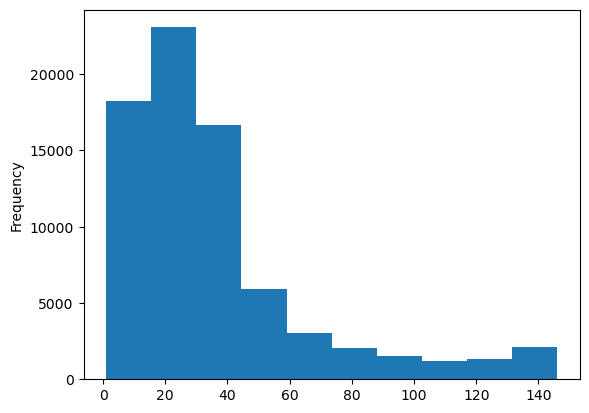

In [42]:
# len 시각화 (label == 0)
import matplotlib.pyplot as plt
df[df.label==0]['len'].plot(kind='hist')

<Axes: ylabel='Frequency'>

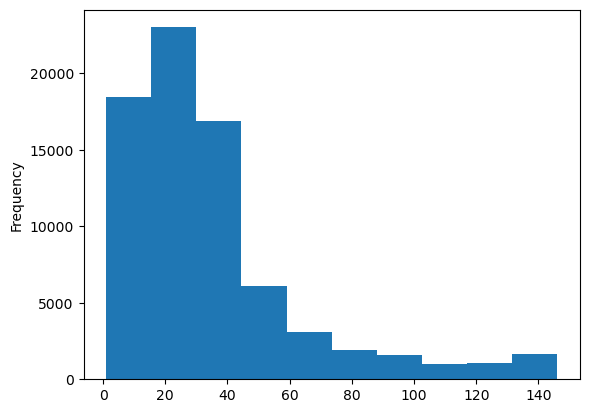

In [43]:
# len 시각화 (label == 1)
import matplotlib.pyplot as plt
df[df.label==1]['len'].plot(kind='hist')

### 데이터 샘플링
- 데이터 개수가 너무 많아서 df[:1000] 개의 데이터로만 머신러닝

In [44]:
df = df[:1000]
df.shape

(1000, 4)

In [45]:
# 토큰화
vect = CountVectorizer(tokenizer = tokenizer.morphs)
vectors = vect.fit_transform(df['document'])

### 머신러닝

In [46]:
# 머신러닝 -> 교차검증(f1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state=2025)
cross_val_score(model, vectors, df['label'], scoring='f1', cv=5)

array([0.66292135, 0.63095238, 0.72043011, 0.69651741, 0.61363636])

In [47]:
cross_val_score(model, vectors, df['label'], scoring='f1', cv=5).mean()

0.6648915226731114

## 자연어 전처리 (한글 NLP)
- 어휘 사전 구축
- 불용어(큰 의미가 없는 단어)
- 띄어쓰기
- 반복되는 글자 정리
- 맞춤법 검사

In [48]:
# 어휘 사전 구축
# 토큰화(max_df) N개 보다 큰 단어 수 무시
vect = CountVectorizer(tokenizer = tokenizer.morphs, max_df=10)
vectors = vect.fit_transform(df['document'])
model = RandomForestClassifier(random_state=2025)
cross_val_score(model, vectors, df['label'], scoring='accuracy', cv=5).mean()

0.6520000000000001

In [49]:
# 토큰화(min_df) N개 보다 작은 단어 수 무시
vect = CountVectorizer(tokenizer = tokenizer.morphs, min_df=2)
vectors = vect.fit_transform(df['document'])
model = RandomForestClassifier(random_state=2025)
cross_val_score(model, vectors, df['label'], scoring='accuracy', cv=5).mean()

0.677

In [50]:
# 불용어
# 조사 (Josa), 어미 (Eomi) 들은 대부분 불용어로 제거
text = "오늘 비가 와서 기분이 우울해요"
stop_words = ['오늘', '가','이','해요']
vect = CountVectorizer(stop_words = stop_words)
words = tokenizer.morphs(text)
vect.fit(words)
vect.vocabulary_

{'와서': 1, '기분': 0, '우울해요': 2}

[('오늘', 'Noun'),  
 ('비', 'Noun'),  
 ('가', 'Josa'),  
 ('와서', 'Verb'),  
 ('기분', 'Noun'),  
 ('이', 'Josa'),  
 ('우울해요', 'Adjective')]  

In [51]:
# Spacing 설치
# import sys
# !{sys.executable} -m pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [52]:
# 띄어쓰기
from pykospacing import Spacing
spacing = Spacing()
text = "오늘비가와서기분이우울해요"
spacing(text)

'오늘 비가 와서 기분이 우울해요'

In [53]:
# 반복되는 글자 정리
# import sys
# !{sys.executable} -m pip install soynlp

In [54]:
# 댓글 데이터에 등장하는 반복되는 이모티콘의 정리
from soynlp.normalizer import *
emoticon_normalize('하하하하하하하ㅋㅋㅋㅋㅋㅋㅋㅋ호호호호호호호ㅠㅠㅠㅠㅠ', num_repeats=3)

'하하하ㅋㅋㅋ호호호ㅠㅠㅠ'

In [55]:
# import hanspell
# print(hanspell.__file__)

In [56]:
# !pip install git+https://github.com/9bow/py-hanspell.git

In [57]:
import requests
import json
import re

def naver_spell_check(text):
    url = "https://m.search.naver.com/p/csearch/ocontent/util/SpellerProxy"
    params = {
        'passportKey': 'c9a2c043b06f9a113603bccb0486edbe0c2b223f',
        '_callback': 'jQuery224003210169111106265_1747721803301',
        'q': text,
        'where': 'nexearch',
        'color_blindness': '0',
        '_': "1747721803303"
    }

    response = requests.get(url, params=params)
    print("응답 코드:", response.status_code)
    print("응답 내용 (앞부분):", response.text[:300])

    match = re.search(r'^\w+\((.*)\);?$', response.text.strip())
    if not match:
        raise ValueError("JSONP 응답에서 JSON을 추출할 수 없습니다.")

    json_text = match.group(1)
    try:
        data = json.loads(json_text)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON 디코딩 실패: {e}")

    html = data['message']['result']['html']
    clean_text = re.sub(r'<.+?>', '', html)

    return clean_text

text = '날씨가좋으면 기분이 좋아지지만, 날씨가 좋지 않으면기분이 우울해져요'

try:
    result = naver_spell_check(text)
    print("\n[Naver 맞춤법 결과]")
    print(result)
except Exception as e:
    print(f"\n[오류 발생] {e}")


응답 코드: 200
응답 내용 (앞부분): jQuery224003210169111106265_1747721803301({"message":{"result":{"errata_count":2,"origin_html":"<span class='result_underline'>날씨가좋으면</span> 기분이 좋아지지만, 날씨가 좋지 <span class='result_underline'>않으면기분이</span> 우울해져요","html":"<em class='green_text'>날씨가 좋으면</em> 기분이 좋아지지만, 날씨가 좋지 <em class='green_text'>않으면 

[Naver 맞춤법 결과]
날씨가 좋으면 기분이 좋아지지만, 날씨가 좋지 않으면 기분이 우울해져요


In [58]:
from pykospacing import Spacing
text = '날씨가좋으면 기분이 좋아지지만, 날씨가 좋지 않으면기분이 우울해져요'
spacing = Spacing()
result = spacing(text)
result

'날씨가 좋으면 기분이 좋아지지만, 날씨가 좋지 않으면 기분이 우울해져요'